<a href="https://colab.research.google.com/github/ansariwaleed/EEG/blob/main/EEG_tutorial_preprocesssing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import code from other notebook

In [9]:
import io, os,sys,types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
sys.meta_path.append(NotebookFinder())

In [10]:
from scipy.signal import butter, lfilter
import scipy
import numpy as np

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    y_ = [int(xx) for xx in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]
import numpy as np
def extract(input, n_classes, n_fea, time_window, moving):
    xx = input[:, :n_fea]
    yy = input[:, n_fea:n_fea + 1]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes + 1):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)
        else:
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(0)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Segementation
Next, we show how to segment the data stream. We take 0.1 second as an example of time window, therefore, each segment contains 16=0.6*
160 time steps as the sampling rate is 160 Hz. We set the overlapping rate as 50%, indicating there are 50% overlap between two adjacent segments.

In [12]:
import numpy as np

dataset_1 = np.load("/content/drive/MyDrive/1/1.npy")

n_class = 10 #0-9 classes ('10:rest' is not counted)
no_feature = 64 # the number of features
segment_length = 16 #selected time window

# segment data, check more details about the 'extract' function in BCI_functions.ipynb
data_seg = extract(dataset_1, n_classes=n_class, n_fea=no_feature, time_window=segment_length, moving=(segment_length/2))  # 50% overlapping

print('After segmentation, the shape of the data:', data_seg.shape)

After segmentation, the shape of the data: (32440, 1025)


##Spliting Training and Test data

In [14]:
# Fir# First, we separate the features and the label

data_seg_feature = data_seg[:, :1024]
data_seg_label = data_seg[:, 1024:1025]

# split data
from sklearn.model_selection import train_test_split
train_feature, test_feature, train_label, test_label = train_test_split(data_seg_feature, data_seg_label, shuffle=True)
print('The shape of training feature and label:', train_feature.shape, train_label.shape,
     '\nThe shape of test feature and label:', test_feature.shape, test_label.shape)


The shape of training feature and label: (24330, 1024) (24330, 1) 
The shape of test feature and label: (8110, 1024) (8110, 1)


##Normalization

###Z- score normalization
>Z-score normalization (Standardization) gives you an idea of how far from the mean a data point is.


The equation for z-score normalization:

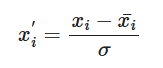


In [18]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler().fit(train_feature)
train_fea_norm1 = scaler1.transform(train_feature) #normalize the training data
test_fea_norm1 = scaler1.transform(test_feature)

print("After nomalization the shape of training features:", train_fea_norm1.shape,
      '\nAfter normalization, the shape of test feature:', test_fea_norm1.shape)

After nomalization the shape of training features: (24330, 1024) 
After normalization, the shape of test feature: (8110, 1024)


###Unifrom normalization(L1)
> For the uniform normalization, it process the dataset in a way that the sum of the absolute value of each column (in our case) to be one.
The equation for uniform normalization:

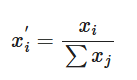


- Note, in sklearn.preprocessing.Normalizer， the default normalization is L2, so remember to set the normalizer to L1 normalization (norm='l1') when you want to use uniform normalization.
- Mind the axis in this one. The normalizer seems to be defaultly scale on the channel-wise axis, in this case, we have to transpose the data in order to get the correct normalization.

In [23]:
from sklearn.preprocessing import Normalizer

# Fit the Normalizer on the original training data (not transposed)
scaler2 = Normalizer(norm='l1').fit(train_feature)

# Transform the original training and test data (not transposed)
train_fea_norm2 = scaler2.transform(train_feature)
test_fea_norm2 = scaler2.transform(test_feature)

print('After normalization, the shape of training feature:', train_fea_norm2.shape,
      '\nAfter normalization, the shape of test feature:', test_fea_norm2.shape)

After normalization, the shape of training feature: (24330, 1024) 
After normalization, the shape of test feature: (8110, 1024)


###Min-max normalization



> Min-max normalization is one of the most common ways to normalize data. For every feature, the minimum value of that feature gets transformed into a 0, the maximum value gets transformed into a 1, and every other value gets transformed into a decimal between 0 and 1.1

The equation for min-max normalization:

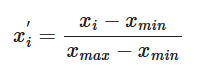


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler3 = MinMaxScaler().fit(train_feature)
train_fea_norm3 = scaler3.transform(train_feature)
test_fea_norm3 = scaler3.transform(test_feature)

print('After normalization, the shape of training feature:', train_fea_norm3.shape,
      '\nAfter normalization, the shape of test feature:', test_fea_norm3.shape)


After normalization, the shape of training feature: (24330, 1024) 
After normalization, the shape of test feature: (8110, 1024)
